# Image Captioing/Report Generation with CNN + LSTM

In [ ]:
import torch
import torchvision
# import torchtext
import torchaudio

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")
# print(f"TorchText version: {torchtext.__version__}")
print(f"TorchAudio version: {torchaudio.__version__}")

# A simple check to ensure torchvision can access torch's C++ extensions
try:
    print(torchvision.extension._check_cuda_version())
    print("\nTorchVision and Torch are correctly linked.")
except Exception as e:
    print(f"\nVerification failed with error: {e}")

PyTorch version: 2.6.0+cu124
TorchVision version: 0.21.0+cu124
TorchAudio version: 2.6.0+cu124
12040

TorchVision and Torch are correctly linked.


In [ ]:
#Imports
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os, warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
torch.backends.cudnn.benchmark = True
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Dataset paths
image_dir = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"
iprojection_dir = "/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv"
ireport_dir = "/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv"
# image_dir, iprojection_dir, ireport_dir
projections = pd.read_csv(iprojection_dir)
reports     = pd.read_csv(ireport_dir)

1. Text Preprocessing:
First, we need to process the report text ("findings" and "impression"). This involves cleaning the text, building a vocabulary, and creating a way to convert text to numbers that our model can understand.

In [ ]:
# Cell 12: Text Preprocessing & Vocabulary Building
import nltk
from collections import Counter

# Download required tokenizer models
nltk.download('punkt')
nltk.download('punkt_tab')

# First, fill any NaN values with an empty string
reports['findings'] = reports['findings'].fillna('')
reports['impression'] = reports['impression'].fillna('')

# Combine them, and use .strip() to remove any leading/trailing whitespace
reports['caption'] = (reports['findings'] + ' ' + reports['impression']).str.strip()

class Vocabulary:
    """Builds a vocabulary from a list of sentences."""
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<START>": 1, "<END>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        # Simple tokenizer: lowercase, tokenize, remove punctuation
        text = text.lower()
        tokens = nltk.tokenize.word_tokenize(text)
        return [word for word in tokens if word.isalpha()]

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

# Build the vocabulary from the report captions
vocab = Vocabulary(freq_threshold=5)
# Make sure to build vocabulary on the new, cleaned 'caption' column
vocab.build_vocabulary(reports['caption'].tolist())
print(f"Vocabulary Size: {len(vocab)}")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Vocabulary Size: 899


2. Update the Dataset and DataLoader:
Now, we'll modify the Dataset class to handle the image-caption pairs. We also need a collate_fn to pad the captions in each batch to be the same length, which is crucial for training RNNs.

In [ ]:
# Cell 13: Dataset and Create DataLoader
from torch.nn.utils.rnn import pad_sequence

# Merge reports metadata with projections
full_df = projections.merge(reports, on='uid')
full_df['filepath'] = full_df['filename'].apply(lambda f: os.path.join(image_dir, f))
full_df = full_df[full_df['filepath'].map(os.path.exists)].reset_index(drop=True)

# Filter out captions that are empty or too short to be informative
initial_count = len(full_df)
# We keep captions that have more than a few words (e.g., > 20 characters)
full_df = full_df[full_df['caption'].str.len() > 20].reset_index(drop=True)
print(f"Original number of examples: {initial_count}")
print(f"Filtered number of examples: {len(full_df)}")
print(f"Removed {initial_count - len(full_df)} low-information captions.")

# Split the data
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

class ChestXrayCaptionDataset(Dataset):
    def __init__(self, df, vocab, transforms):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row['filepath']).convert("RGB")
        img = self.transforms(img)

        caption = row['caption']
        numericalized_caption = [self.vocab.stoi["<START>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<END>"])

        return img, torch.tensor(numericalized_caption)

class Collate:
    """Pads captions to the same length in a batch."""
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)
        return imgs, targets

# image transforms
IMG_SIZE = 224
transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Create datasets
train_dataset = ChestXrayCaptionDataset(train_df, vocab, transforms)
val_dataset = ChestXrayCaptionDataset(val_df, vocab, transforms)

# Create data loaders
BATCH_SIZE = 32
pad_idx = vocab.stoi["<PAD>"]
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=Collate(pad_idx=pad_idx),
    pin_memory=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=Collate(pad_idx=pad_idx),
    pin_memory=True
)

Original number of examples: 7466
Filtered number of examples: 7400
Removed 66 low-information captions.


3. Build the CNN-LSTM Model:
Here we define the encoder (CNN) and decoder (LSTM). We'll use a pre-trained ResNet-152 for its powerful feature extraction capabilities.

In [ ]:
# Cell 14: Define the CNN-LSTM Model with Beam Search
import torchvision.models as models
import torch.nn.functional as F

class CNNEncoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet152(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return self.bn(features)

class LSTMDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers, # If we want to use stack of LSTM
            batch_first=True,
            bidirectional=False
        )
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

class CNN_LSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        self.encoder = CNNEncoder(embed_size)
        self.decoder = LSTMDecoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    # --- BEAM SEARCH ---
    def caption_image(self, image, vocabulary, max_length=100, beam_width=5):
        self.eval()
        with torch.no_grad():
            features = self.encoder(image)
            start_token_idx = vocabulary.stoi["<START>"]

            hiddens, states = self.decoder.lstm(features.unsqueeze(1))
            outputs = self.decoder.linear(hiddens.squeeze(1))
            log_probs = F.log_softmax(outputs, dim=1)

            top_log_probs, top_indices = log_probs.topk(beam_width)

            k_sequences = []
            for i in range(beam_width):
                seq = [start_token_idx, top_indices[0][i].item()]
                score = top_log_probs[0][i].item()
                k_sequences.append((score, seq, states))

            complete_sequences = []
            for _ in range(max_length):
                all_candidates = []
                for score, seq_indices, states in k_sequences:
                    last_word_idx = torch.tensor([seq_indices[-1]], device=image.device)
                    word_embeddings = self.decoder.embed(last_word_idx).unsqueeze(1)
                    hiddens, new_states = self.decoder.lstm(word_embeddings, states)
                    outputs = self.decoder.linear(hiddens.squeeze(1))
                    log_probs = F.log_softmax(outputs, dim=1)

                    top_log_probs, top_indices = log_probs.topk(beam_width)
                    for i in range(beam_width):
                        next_word_idx = top_indices[0][i].item()
                        new_seq_indices = seq_indices + [next_word_idx]
                        new_score = score + top_log_probs[0][i].item()
                        if next_word_idx == vocabulary.stoi["<END>"]:
                            complete_sequences.append((new_score / len(new_seq_indices), new_seq_indices))
                        else:
                            all_candidates.append((new_score, new_seq_indices, new_states))

                if not all_candidates: break
                ordered = sorted(all_candidates, key=lambda tup: tup[0], reverse=True)
                k_sequences = ordered[:beam_width]

        if not complete_sequences:
            complete_sequences = [(score / len(seq), seq) for score, seq, _ in k_sequences]

        best_seq = sorted(complete_sequences, key=lambda tup: tup[0], reverse=True)[0]
        return [vocabulary.itos[idx] for idx in best_seq[1]]

4. Training the Report Generation Model:
Finally, we'll set up the hyperparameters, instantiate the model, and write the training loop. This loop is more complex than the one for classification because we're predicting a sequence of words.

In [ ]:
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

CUDA available: True
Using device: cuda


In [ ]:
# Cell 15: Set Hyperparameters and Train the Model (Loss and Perplexity only)

# Hyperparameters
embed_size = 512
hidden_size = 512
num_layers = 1
learning_rate = 3e-4
num_epochs = 50

# Instantiate the model
model = CNN_LSTM(embed_size, hidden_size, len(vocab), num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss history for plotting
training_losses = []
validation_losses = []
validation_perplexities = []

# Training loop
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for i, (imgs, captions) in enumerate(train_loader):
        imgs = imgs.to(device)
        captions = captions.to(device)

        captions_input = captions[:, :-1]
        captions_target = captions[:, 1:]

        outputs = model(imgs, captions_input)
        loss = criterion(outputs[:, :captions_target.shape[1], :].reshape(-1, outputs.shape[2]), captions_target.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i + 1) % 150 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    training_losses.append(avg_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for i, (imgs, captions) in enumerate(val_loader):
            imgs = imgs.to(device)
            captions = captions.to(device)

            captions_input = captions[:, :-1]
            captions_target = captions[:, 1:]

            outputs = model(imgs, captions_input)
            val_loss = criterion(outputs[:, :captions_target.shape[1], :].reshape(-1, outputs.shape[2]), captions_target.reshape(-1))
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)

    perplexity = math.exp(avg_val_loss)
    validation_perplexities.append(perplexity)

    # print statement
    print(f"Epoch {epoch} -> Training Loss: {avg_loss:.4f} | Validation Loss: {avg_val_loss:.4f} | Validation Perplexity: {perplexity:.2f}")

Epoch [1/50], Step [150/185], Loss: 4.1081
Epoch 1 -> Training Loss: 4.5208 | Validation Loss: 3.7142 | Validation Perplexity: 41.03
Epoch [2/50], Step [150/185], Loss: 3.5733
Epoch 2 -> Training Loss: 3.5481 | Validation Loss: 3.2974 | Validation Perplexity: 27.04
Epoch [3/50], Step [150/185], Loss: 2.7553
Epoch 3 -> Training Loss: 3.2379 | Validation Loss: 3.0680 | Validation Perplexity: 21.50
Epoch [4/50], Step [150/185], Loss: 2.8704
Epoch 4 -> Training Loss: 3.0371 | Validation Loss: 2.9163 | Validation Perplexity: 18.47
Epoch [5/50], Step [150/185], Loss: 2.9682
Epoch 5 -> Training Loss: 2.8850 | Validation Loss: 2.7982 | Validation Perplexity: 16.41
Epoch [6/50], Step [150/185], Loss: 2.6189
Epoch 6 -> Training Loss: 2.7528 | Validation Loss: 2.7079 | Validation Perplexity: 15.00
Epoch [7/50], Step [150/185], Loss: 2.8520
Epoch 7 -> Training Loss: 2.6491 | Validation Loss: 2.6266 | Validation Perplexity: 13.83
Epoch [8/50], Step [150/185], Loss: 2.6039
Epoch 8 -> Training Loss: 

5. Inference: Generating a Report:
After training, we'll want to see how well our model performs. Here's a function to take a random image from the validation set, display it, and show the generated report alongside the original one.

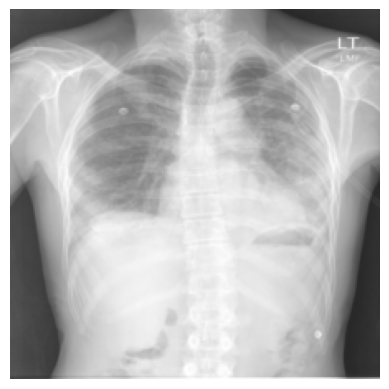

----- Original Report -----
patchy bilateral opacities <UNK> in the lung bases <UNK> features are most consistent with pneumonia aspiration or edema are also possible but less xxxx xxxx lung volumes no pneumothorax

----- Generated Report -----
the there low volumes the silhouette and are the costophrenic are the and are the are the are the and are the and are the upper normal <UNK> <UNK> xxxx normal and changes both are and opacities <UNK> the


In [ ]:
# Cell 16: Inference and Report Generation
import random

def generate_and_display_report(dataset, model, vocab, device, idx=None):
    """Selects an image, generates a report, and displays results."""
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    model.eval()

    # Get image and original caption
    img, caption_tensor = dataset[idx]
    original_caption = " ".join([vocab.itos[i.item()] for i in caption_tensor if i not in [0,1,2]]) # Exclude PAD, START, END

    # Move image to device and generate report
    img_tensor = img.unsqueeze(0).to(device)
    generated_caption_tokens = model.caption_image(img_tensor, vocab)

    # --- 1: ROBUSTLY HANDLE <END> TOKEN ---
    try:
        # Find the first occurrence of the <END> token
        end_idx = generated_caption_tokens.index("<END>")
        # Take everything before the <END> token
        generated_caption_tokens = generated_caption_tokens[:end_idx]
    except ValueError:
        # If <END> is not found, just use the whole sequence (excluding start)
        pass

    # Join the tokens to form the final caption string
    generated_caption = " ".join(generated_caption_tokens[1:]) # Exclude <START> if it's there

    # --- 2: DE-NORMALIZE IMAGE FOR CORRECT DISPLAY ---
    # The normalization was (img - 0.5) / 0.5, so the reverse is (img * 0.5) + 0.5
    img_display = img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5

    # Display the de-normalized image
    plt.imshow(img_display)
    plt.axis('off')
    plt.show()

    print("----- Original Report -----")
    print(original_caption)
    print("\n----- Generated Report -----")
    print(generated_caption)

# Generate a report for a random image in the validation set
generate_and_display_report(val_dataset, model, vocab, device)

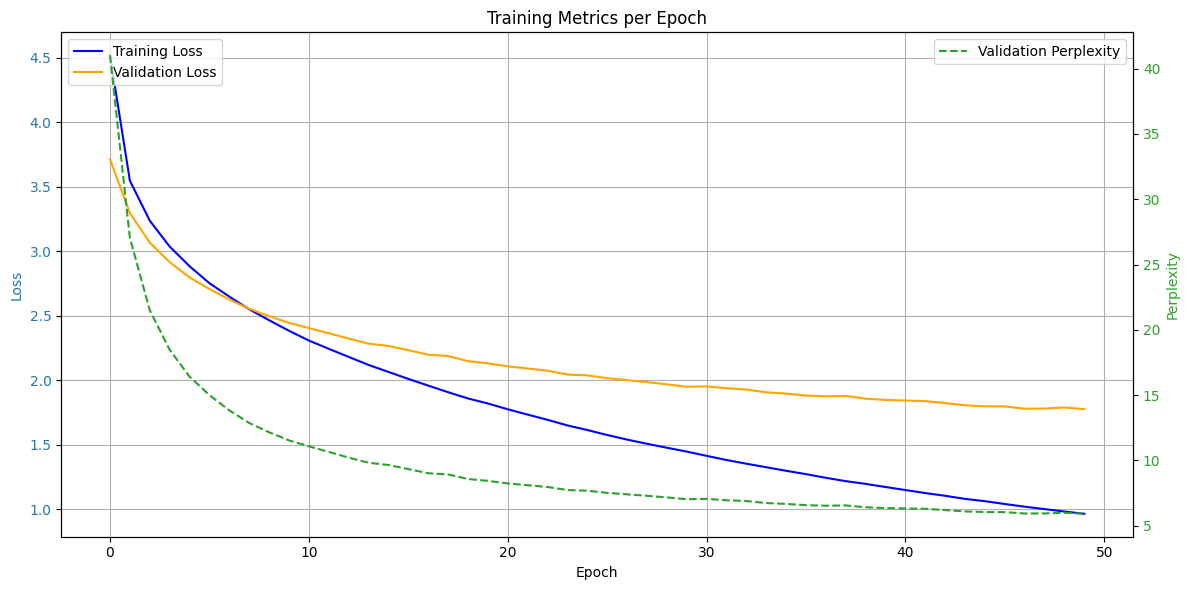

In [ ]:
# Cell 17: Visualize Loss and Perplexity
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Training & Validation Loss on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(training_losses, label='Training Loss', color='blue', linestyle='-')
ax1.plot(validation_losses, label='Validation Loss', color='orange', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a second y-axis for Perplexity on the same plot
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Perplexity', color=color)
ax2.plot(validation_perplexities, label='Validation Perplexity', color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('Training Metrics per Epoch')
fig.tight_layout()
plt.show()

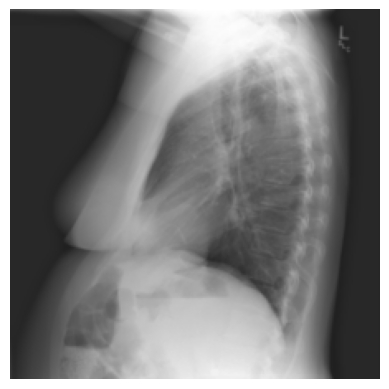

----- Original Report -----
heart size mediastinal contour and pulmonary vascularity are within normal limits no focal consolidation suspicious pulmonary opacity large pleural effusion or pneumothorax is identified visualized osseous structures appear intact no acute cardiopulmonary abnormality

----- Generated Report (Raw) -----
there scattered granulomas changes <UNK> the the and are the contours normal <UNK> <UNK> the pulmonary and are the structures within limits mildly there no pulmonary congestion bibasilar infiltrates atelectasis pulmonary congestion xxxx

----- Generated Report (Post-Processed) -----
There scattered granulomas changes the and are the contours normal the pulmonary and are the structures within limits mildly there no pulmonary congestion bibasilar infiltrates atelectasis pulmonary congestion.


In [ ]:
# Cell 16 (Combined): Inference, Post-Processing, and Visualization
import random
import re
import matplotlib.pyplot as plt

# --- Post-Processing Helper Functions ---

def remove_repetition_patterns(text):
    """Removes consecutive repeated words AND repeating phrases (e.g., 'are the are the')."""
    # Remove repeating phrases of 2 words
    text = re.sub(r'\b(\w+\s+\w+)(\s+\1\b)+', r'\1', text, flags=re.IGNORECASE)
    # Remove repeating single words
    text = re.sub(r'\b(\w+)(\s+\1\b)+', r'\1', text, flags=re.IGNORECASE)
    return text

def clean_garbage_tokens(text):
    """Removes placeholder and unknown tokens."""
    garbage = ['xxxx', '<unk>', '<UNK>', 'xxx']
    for g in garbage:
        text = text.replace(g, '')
    return text.strip()

def format_text(text):
    """Normalizes whitespace, capitalizes the first letter, and adds a period."""
    text = re.sub(r'\s+', ' ', text).strip()
    if text:
        text = text[0].upper() + text[1:]
        if not text.endswith('.'):
            text += '.'
    return text

def post_process_report(text):
    """Applies all cleaning and formatting steps to the raw text."""
    text = text.lower()
    text = remove_repetition_patterns(text)
    text = clean_garbage_tokens(text)
    text = format_text(text)
    return text


# --- Main Inference and Display Function ---

def generate_and_display_report(dataset, model, vocab, device, idx=None):
    """Selects an image, generates a report, displays results, and shows a cleaned version."""
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    model.eval()
    img, caption_tensor = dataset[idx]
    original_caption = " ".join([vocab.itos[i.item()] for i in caption_tensor if i not in [0, 1, 2]])

    img_tensor = img.unsqueeze(0).to(device)
    generated_caption_tokens = model.caption_image(img_tensor, vocab)

    try:
        end_idx = generated_caption_tokens.index("<END>")
        generated_caption_tokens = generated_caption_tokens[:end_idx]
    except ValueError:
        pass

    raw_generated_caption = " ".join(generated_caption_tokens[1:])
    cleaned_caption = post_process_report(raw_generated_caption)

    img_display = img.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5

    plt.imshow(img_display)
    plt.axis('off')
    plt.show()

    print("----- Original Report -----")
    print(original_caption)
    print("\n----- Generated Report (Raw) -----")
    print(raw_generated_caption)
    print("\n----- Generated Report (Post-Processed) -----")
    print(cleaned_caption)

# --- Execute the full pipeline ---
generate_and_display_report(val_dataset, model, vocab, device)